In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
random.seed(1228)
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
import re
from pymystem3 import Mystem
import numpy as np
import itertools
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import toktok
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer

import gensim
import string

from nltk.stem.snowball import RussianStemmer
import seaborn as sns

### загрузка датасета

In [2]:
data = pd.read_csv("data_raw299.csv", sep=';')

In [3]:
data.head()

,id,rank,relevant,text
0,1,1,1,\tЯ очень расстроена! Пошли в межсерверную бит...
1,2,5,1,"\tУважаемые разработчики, благодарю за ваш отв..."
2,3,5,1,\tИграю с ноября. До сих пор не надоедает. Доб...
3,4,2,1,"\tУ меня Клара виснит,она бывает прозрачной ил..."
4,5,5,0,\tЛучшая игра!


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
id          299 non-null int64
rank        299 non-null int64
relevant    299 non-null int64
text        299 non-null object
dtypes: int64(3), object(1)
memory usage: 9.4+ KB


In [6]:
data['relevant'].value_counts()

1    183
0    116
Name: relevant, dtype: int64

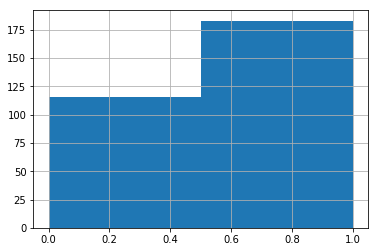

In [120]:
hist = data['relevant'].hist(bins=2)

### удаляем все символы кроме буквенных

In [7]:
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return "ошибка"

In [8]:
data.text = data.text.apply(words_only)
data.head()

,id,rank,relevant,text
0,1,1,1,Я очень расстроена Пошли в межсерверную битву ...
1,2,5,1,Уважаемые разработчики благодарю за ваш ответ ...
2,3,5,1,Играю с ноября До сих пор не надоедает Добавля...
3,4,2,1,У меня Клара виснит она бывает прозрачной или ...
4,5,5,0,Лучшая игра


### проверка написания слов

In [9]:
from pyaspeller import YandexSpeller

def spell_check(text):
        speller = YandexSpeller()
        changes = []
        try:
                changes = {change['word']: change['s'][0] for change in speller.spell(text)}
                for word, suggestion in changes.items():
                     text = text.replace(word, suggestion)
        except:
             text = text     
        return text

In [10]:
data.text = data.text.apply(spell_check)
data.to_csv("clean_data299.csv")
data.head()

,id,rank,relevant,text
0,1,1,1,Я очень расстроена Пошли в межсерверную битву ...
1,2,5,1,Уважаемые разработчики благодарю за ваш ответ ...
2,3,5,1,Играю с ноября До сих пор не надоедает Добавля...
3,4,2,1,У меня Клара виснет она бывает прозрачной или ...
4,5,5,0,Лучшая игра


###

In [14]:
clean_data = pd.read_csv("clean_data299.csv")
clean_data.head()

,Unnamed: 0,id,rank,relevant,text
0,0,1,1,1,Я очень расстроена Пошли в межсерверную битву ...
1,1,2,5,1,Уважаемые разработчики благодарю за ваш ответ ...
2,2,3,5,1,Играю с ноября До сих пор не надоедает Добавля...
3,3,4,2,1,У меня Клара виснет она бывает прозрачной или ...
4,4,5,5,0,Лучшая игра


In [15]:
data.head()

,id,rank,relevant,text
0,1,1,1,Я очень расстроена Пошли в межсерверную битву ...
1,2,5,1,Уважаемые разработчики благодарю за ваш ответ ...
2,3,5,1,Играю с ноября До сих пор не надоедает Добавля...
3,4,2,1,У меня Клара виснет она бывает прозрачной или ...
4,5,5,0,Лучшая игра


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 4 columns):
id          299 non-null int64
rank        299 non-null int64
relevant    299 non-null int64
text        299 non-null object
dtypes: int64(3), object(1)
memory usage: 9.4+ KB


### Лемматизация

In [17]:
%%time 
from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return "ошибка"



CPU times: user 239 µs, sys: 138 µs, total: 377 µs
Wall time: 311 µs


In [18]:
clean_data.text = clean_data.text.apply(lemmatize)
clean_data.head()

,Unnamed: 0,id,rank,relevant,text
0,0,1,1,1,я очень расстраивать пойти в межсерверный битв...
1,1,2,5,1,уважаемый разработчик благодарить за ваш ответ...
2,2,3,5,1,играть с ноябрь до сей пора не надоедать добав...
3,3,4,2,1,у я клара виснуть она бывать прозрачный или в ...
4,4,5,5,0,хороший игра


In [19]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm

cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(clean_data.iterrows(), total = len(clean_data)):
    tokens = row['text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('не', 308)
('и', 273)
('игра', 237)
('я', 183)
('в', 173)
('что', 137)
('а', 114)
('на', 114)
('быть', 96)
('вы', 84)


### удаление стоп слов

In [20]:
from nltk.corpus import stopwords

In [21]:
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', 
                                            'мой', 'очень', 'день', ',', 'просто', 'этот', 'вообще','что',
                                            'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...',
                                             'е', 'либо', '!', 'a', 'оно', 'л',]
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return "ошибка"

In [22]:
clean_data.text = clean_data.text.apply(remove_stopwords) 
clean_data.head()

,Unnamed: 0,id,rank,relevant,text
0,0,1,1,1,расстраивать пойти межсерверный битва случатьс...
1,1,2,5,1,уважаемый разработчик благодарить ваш ответ во...
2,2,3,5,1,играть ноябрь сей пора надоедать добавлять инт...
3,3,4,2,1,клара виснуть бывать прозрачный клеточка прогу...
4,4,5,5,0,хороший игра


In [24]:
from collections import Counter
from tqdm import tqdm_notebook as tqdm
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
for index, row in tqdm(clean_data.iterrows(), total = len(clean_data)):
    tokens = row['text'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
for i in cnt.most_common(10):
    print(i)


('игра', 237)
('уровень', 74)
('играть', 62)
('герой', 52)
('разработчик', 45)
('время', 38)
('мочь', 35)
('донат', 33)
('проходить', 33)
('который', 31)


## Обучение моделей

### Разбивка данных на обучающую и тестовые выборки, векторизация слов bag of words

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer(analyzer='word', tokenizer=word_tokenize, lowercase=False)
#analyzer='word', decode_error='replace', lowercase=False 
    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

list_corpus = clean_data["text"].tolist()
list_labels = clean_data["relevant"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.3, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [30]:
len(count_vectorizer.get_feature_names())

1364

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier

### Обучение логистической регрессии без подбора параметров

In [32]:
clf_lr1 = LogisticRegression(C=35, solver='newton-cg', 
                         n_jobs=-1, random_state=40)
clf_lr1.fit(X_train_counts, y_train)

y_predicted_counts = clf_lr1.predict(X_test_counts)

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1


accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.722, precision = 0.752, recall = 0.722, f1 = 0.722


In [34]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf_lr1, 10)

In [35]:
importance

{0: {'tops': [(2.507139175579046, 'постоянно'),
   (2.537919340901932, 'вылетать'),
   (2.607397295447999, 'играть'),
   (2.645791757014576, 'новый'),
   (2.7408292222702197, 'проходить'),
   (2.8938592111871477, 'понравиться'),
   (2.910837577816656, 'мир'),
   (3.0366815645472487, 'па'),
   (3.148013388234801, 'скачать'),
   (3.379310562708408, 'причина')],
  'bottom': [(-1.3863545819478624, 'назойливый'),
   (-1.3863545819478624, 'пожалеть'),
   (-1.3863545819478624, 'являться'),
   (-1.4064604124224733, 'далеко'),
   (-1.434540424592367, 'крутой'),
   (-1.4556761292291245, 'делить'),
   (-1.4556761292291245, 'четвертый'),
   (-1.6577800628832335, 'тупой'),
   (-1.7130255863853883, 'нужный'),
   (-2.194545475830545, 'интересный')]}}

### подбор параметров модели

In [36]:
clf_lr = LogisticRegression()

In [37]:
param_dist_lr = { "penalty" : ['l2'],
                "C" : [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 3.4, 5.5, 7.5, 10, 15, 20, 30, 35],
                "solver" : ['newton-cg', 'lbfgs', 'sag', 'saga' ]
                }

In [38]:
grid_lr = GridSearchCV(clf_lr, param_dist_lr, scoring='f1_weighted', cv=10)
grid_lr.fit(X_train_counts, y_train)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cl

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cl

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-pack

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 3.4, 5.5, 7.5, 10, 15, 20, 30, 35], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [39]:
print(grid_lr.best_params_)
print(grid_lr.best_score_)
print(grid_lr.best_estimator_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.837680307460781
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)


In [40]:
y_pred_lr = grid_lr.predict(X_test_counts)

In [41]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_lr)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.767, precision = 0.766, recall = 0.767, f1 = 0.765


### добавление векторизации TF IDF 

In [42]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=word_tokenize,
    preprocessor=None, max_features=6000)

    emb = tfidf_vectorizer.fit_transform(data)

    return emb, tfidf_vectorizer

list_corpus2 = clean_data["text"].tolist()
list_labels2 = clean_data["relevant"].tolist()

X_train2, X_test2, y_train2, y_test2 = train_test_split(list_corpus2, list_labels2, test_size=0.3, 
                                                                                random_state=40)

X_train_counts2, tfidf_vectorizer = tfidf(X_train2)
X_test_counts2 = tfidf_vectorizer.transform(X_test2)

In [43]:
len(tfidf_vectorizer.get_feature_names())

1363

In [44]:
clf_lr2 = LogisticRegression()

In [45]:
param_dist_lr = { "penalty" : ['l2'],
                "C" : [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 3.4, 5.5, 7.5, 10, 15, 20, 30, 35],
                "solver" : ['newton-cg', 'lbfgs', 'sag', 'saga' ] }

In [46]:
grid_lr2 = GridSearchCV(clf_lr2, param_dist_lr, scoring='f1_weighted', cv=10)
grid_lr2.fit(X_train_counts2, y_train2)

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/cl

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-pack

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 3.4, 5.5, 7.5, 10, 15, 20, 30, 35], 'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [47]:
print(grid_lr2.best_params_)
print(grid_lr2.best_score_)
print(grid_lr2.best_estimator_)

{'C': 30, 'penalty': 'l2', 'solver': 'saga'}
0.7639875955819773
LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)


In [48]:
y_pred_lr2 = grid_lr2.predict(X_test_counts2)

In [49]:
accuracy, precision, recall, f1 = get_metrics(y_test2, y_pred_lr2)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.678, precision = 0.676, recall = 0.678, f1 = 0.670


### подбор параметров для модели naive_bayes

In [50]:
clf_naive = naive_bayes.MultinomialNB()

In [51]:
param_dist_naive = {
             'alpha':[1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
}

In [52]:
grid_naive = GridSearchCV(clf_naive, param_dist_naive, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_naive.fit(X_train_counts, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [53]:
print(grid_naive.best_params_)
print(grid_naive.best_score_)
print(grid_naive.best_estimator_)

{'alpha': 0.0001}
0.7805689061972758
MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)


In [54]:
y_pred_naive = grid_naive.predict(X_test_counts)

In [55]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_naive)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.678, precision = 0.720, recall = 0.678, f1 = 0.640


In [56]:
clf_naive2 = naive_bayes.MultinomialNB()

In [57]:
grid_naive2 = GridSearchCV(clf_naive2, param_dist_naive, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_naive2.fit(X_train_counts2, y_train2)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1, 0.1, 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [58]:
print(grid_naive2.best_params_)
print(grid_naive2.best_score_)
print(grid_naive2.best_estimator_)

{'alpha': 0.0001}
0.7557764494377346
MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)


In [59]:
y_pred_naive2 = grid_naive2.predict(X_test_counts2)

In [60]:
accuracy, precision, recall, f1 = get_metrics(y_test2, y_pred_naive2)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.678, precision = 0.720, recall = 0.678, f1 = 0.640


### подбор параметров для модели RandomForest

In [61]:
clf_rf = RandomForestClassifier()

In [62]:
param_dist_rf = {
    'n_estimators': [5, 10, 20, 40],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, None],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

In [63]:
grid_forest = GridSearchCV(clf_rf, param_dist_rf, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_forest.fit(X_train_counts, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 40], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 3, 5, 7, 9, None], 'min_samples_leaf': [1, 2, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [64]:
print(grid_forest.best_params_)
print(grid_forest.best_score_)
print(grid_forest.best_estimator_)

{'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 40}
0.8111287793002856
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [65]:
y_pred_rf = grid_forest.predict(X_test_counts)

In [66]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_rf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.722, precision = 0.727, recall = 0.722, f1 = 0.713


In [67]:
clf_rf2 = RandomForestClassifier()

In [68]:
grid_forest2 = GridSearchCV(clf_rf2, param_dist_rf, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_forest2.fit(X_train_counts2, y_train2)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [5, 10, 20, 40], 'criterion': ['gini', 'entropy'], 'max_depth': [1, 3, 5, 7, 9, None], 'min_samples_leaf': [1, 2, 4, 8, 16]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [69]:
print(grid_forest2.best_params_)
print(grid_forest2.best_score_)
print(grid_forest2.best_estimator_)

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 20}
0.8143524949224421
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [70]:
y_pred_rf2 = grid_forest2.predict(X_test_counts2)

In [71]:
accuracy, precision, recall, f1 = get_metrics(y_test2, y_pred_rf2)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.722, precision = 0.721, recall = 0.722, f1 = 0.722


### подбор модели svc

In [72]:
clf_svc = svm.SVC()

In [73]:
param_dist_svc = {
             'C':[1,10,100,1000],
             'gamma':[1,0.1,0.001,0.0001], 
             'kernel':['linear','rbf','sigmoid']
}

In [74]:
grid_svc = GridSearchCV(clf_svc, param_dist_svc, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_svc.fit(X_train_counts, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.001, 0.0001], 'kernel': ['linear', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [75]:
print(grid_svc.best_params_)
print(grid_svc.best_score_)
print(grid_svc.best_estimator_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
0.840109561505953
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [76]:
y_pred_svc = grid_svc.predict(X_test_counts)

In [77]:
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred_svc)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.789, precision = 0.792, recall = 0.789, f1 = 0.790


In [78]:
import collections
collections.Counter(y_pred_svc)

Counter({1: 48, 0: 42})

In [79]:
import collections
collections.Counter(y_test)

Counter({1: 51, 0: 39})

In [ ]:
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [80]:
clf_svc2 = svm.SVC()

In [81]:
grid_svc2 = GridSearchCV(clf_svc2, param_dist_svc, scoring='f1_weighted', cv=10, n_jobs=-1)
grid_svc2.fit(X_train_counts2, y_train2)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.001, 0.0001], 'kernel': ['linear', 'rbf', 'sigmoid']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [82]:
print(grid_svc2.best_params_)
print(grid_svc2.best_score_)
print(grid_svc2.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'linear'}
0.7616561491484092
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [83]:
y_pred_svc2 = grid_svc2.predict(X_test_counts2)

In [84]:
accuracy, precision, recall, f1 = get_metrics(y_test2, y_pred_svc2)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.711, precision = 0.710, recall = 0.711, f1 = 0.710


### лучшая модель с кросс-валидацией

In [85]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [86]:
list_corpus = clean_data["text"].tolist()
list_labels = clean_data["relevant"].tolist()

list_corpus_counts = count_vectorizer.transform(list_corpus)

In [87]:
list_corpus2 = clean_data["text"].tolist()
list_labels2 = clean_data["relevant"].tolist()

list_corpus2_counts2 = tfidf_vectorizer.transform(list_corpus2)

In [88]:
clf_svc_fin = svm.SVC(kernel='rbf', C=10, gamma=0.1)
scores = cross_val_score(clf_svc_fin, list_corpus_counts, list_labels, cv=10)
scores

array([0.83870968, 0.87096774, 0.61290323, 0.8       , 0.93333333,
       0.96666667, 0.72413793, 0.93103448, 0.82758621, 0.62068966])

In [ ]:
f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

In [89]:
print(scores.mean(), scores.std())

0.812602892102336 0.1188888459233091


In [90]:
clf_svc_fin2 = svm.SVC(kernel='rbf', C=10, gamma=0.1)
scores2 = cross_val_score(clf_svc_fin2, list_corpus2_counts2, list_labels2, cv=10)
scores2

array([0.67741935, 0.70967742, 0.70967742, 0.7       , 0.8       ,
       0.86666667, 0.75862069, 0.75862069, 0.72413793, 0.65517241])

In [91]:
print(scores2.mean(), scores2.std())

0.7359992584352985 0.05914425148445188


### тренировка на LDA features

In [92]:
from gensim.corpora import *
texts = [clean_data.text.iloc[i].split() for i in range(len(clean_data))]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [93]:
from gensim import corpora
clean_data["tok_text"] = clean_data["text"].map(lambda x: x.split(' '))
dictionary = corpora.Dictionary(clean_data["tok_text"])

In [94]:
clean_data["bow"] = clean_data["tok_text"].map(dictionary.doc2bow)

In [95]:
clean_data.head()

,Unnamed: 0,id,rank,relevant,text,tok_text,bow
0,0,1,1,1,расстраивать пойти межсерверный битва случатьс...,"[расстраивать, пойти, межсерверный, битва, слу...","[(0, 4), (1, 1), (2, 3), (3, 1), (4, 2), (5, 1..."
1,1,2,5,1,уважаемый разработчик благодарить ваш ответ во...,"[уважаемый, разработчик, благодарить, ваш, отв...","[(2, 1), (8, 2), (9, 1), (17, 1), (18, 1), (26..."
2,2,3,5,1,играть ноябрь сей пора надоедать добавлять инт...,"[играть, ноябрь, сей, пора, надоедать, добавля...","[(10, 1), (37, 1), (41, 1), (57, 1), (58, 2), ..."
3,3,4,2,1,клара виснуть бывать прозрачный клеточка прогу...,"[клара, виснуть, бывать, прозрачный, клеточка,...","[(83, 3), (84, 1), (85, 1), (86, 1), (87, 3), ..."
4,4,5,5,0,хороший игра,"[хороший, игра]","[(103, 1), (104, 1)]"


In [96]:
print("Found {} words.".format(len(dictionary.values())))

Found 1687 words.


In [97]:
%%time
from gensim.models import  *
from gensim import similarities

tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

CPU times: user 113 ms, sys: 4.52 ms, total: 117 ms
Wall time: 110 ms


In [98]:
%%time
lda = ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=25,
                        alpha='auto', eta='auto', iterations = 20, passes = 5)

CPU times: user 732 ms, sys: 4.97 ms, total: 737 ms
Wall time: 737 ms


In [106]:
lda.show_topics(5)

[(4,
  '0.020*"тупой" + 0.015*"игра" + 0.010*"хотеть" + 0.010*"проходить" + 0.009*"месяц" + 0.009*"звезда" + 0.009*"самый" + 0.009*"отзыв" + 0.009*"исправлять" + 0.009*"ставить"'),
 (24,
  '0.018*"уровень" + 0.017*"ход" + 0.017*"ваш" + 0.012*"играть" + 0.011*"сложный" + 0.011*"реклама" + 0.011*"убогий" + 0.008*"игра" + 0.007*"разработчик" + 0.007*"борить"'),
 (14,
  '0.056*"игра" + 0.023*"новый" + 0.020*"уровень" + 0.018*"давать" + 0.016*"хороший" + 0.010*"играть" + 0.010*"время" + 0.009*"хотеть" + 0.009*"вс" + 0.009*"наложница"'),
 (3,
  '0.055*"игра" + 0.015*"уровень" + 0.012*"удалять" + 0.012*"мочь" + 0.011*"борить" + 0.009*"обновление" + 0.009*"игрок" + 0.009*"становиться" + 0.009*"ничто" + 0.009*"деньги"'),
 (19,
  '0.047*"игра" + 0.036*"играть" + 0.020*"уровень" + 0.016*"становиться" + 0.013*"борить" + 0.011*"донат" + 0.010*"разработчик" + 0.009*"ничто" + 0.009*"частность" + 0.008*"деньги"')]

In [99]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = lda_model.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

clean_data['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(lda, doc),
                                      clean_data.bow))

In [100]:
clean_data['lda_features'].head()

0    [0.0009623763617128134, 0.0009456410189159214,...
1    [0.0008474271162413061, 0.0008326906827278435,...
2    [0.001149481744505465, 0.0011294926516711712, ...
3    [0.0013717239489778876, 0.0013478701002895832,...
4    [0.012399241328239441, 0.012183623388409615, 0...
Name: lda_features, dtype: object

In [101]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [102]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)
cleansed_words_df.head()

,count
игра,170
играть,48
уровень,45
разработчик,43
время,34


In [151]:
relevant_words = list(np.concatenate(clean_data.loc[clean_data.relevant == 1, 'tok_text'].values))
non_relevant_words = list(np.concatenate(clean_data.loc[clean_data.relevant == 0, 'tok_text'].values))

In [152]:
relevant_word_frequencies = {word: relevant_words.count(word) for word in cleansed_words_df.index[:30]}
non_relevant_word_frequencies = {word: non_relevant_words.count(word) for word in cleansed_words_df.index[:30]}

In [153]:
frequencies_df = pd.DataFrame(index=cleansed_words_df.index[:30])

In [154]:
frequencies_df['rel_freq'] = list(map(lambda word:
                                      rerlevant_word_frequencies[word],
                                      frequencies_df.index))
frequencies_df['non_rel_freq'] = list(map(lambda word:
                                           non_relevant_word_frequencies[word],
                                          frequencies_df.index))

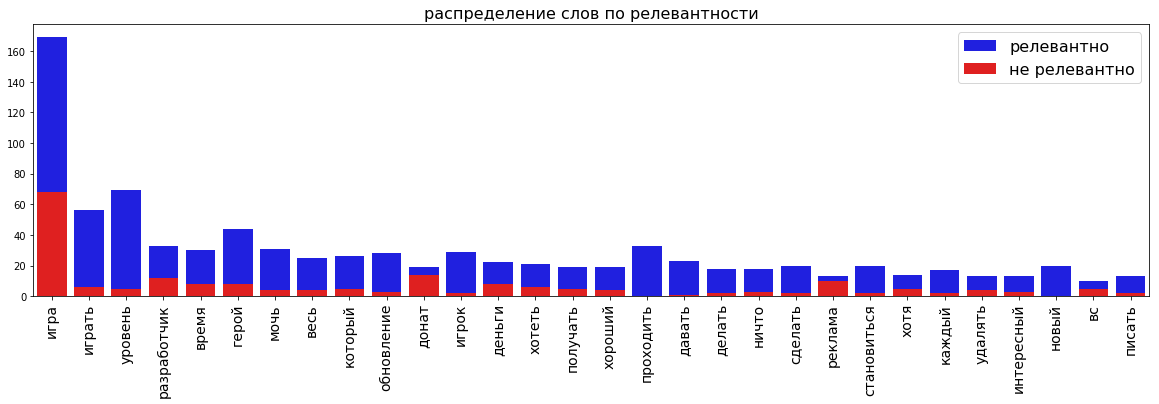

In [159]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

nr_top_words = len(frequencies_df)
nrs = list(range(nr_top_words))
sns.barplot(nrs, frequencies_df['rel_freq'].values, color='b', ax=ax, label="релевантно")
sns.barplot(nrs, frequencies_df['non_rel_freq'].values, color='r', ax=ax, label="не релевантно")

ax.set_title("распределение слов по релевантности", fontsize=16)
ax.legend(prop={'size': 16})
ax.set_xticks(nrs)
ax.set_xticklabels(frequencies_df.index, fontsize=14, rotation=90);

In [103]:
X_train_lda = np.array(list(map(np.array, clean_data['lda_features'])))

In [104]:

clf_svc_fin3 = svm.SVC(kernel='rbf', C=10, gamma=0.1)
scores3 = cross_val_score(clf_svc_fin3, X_train_lda, clean_data['relevant'], cv=10)
scores3

array([0.51612903, 0.61290323, 0.61290323, 0.56666667, 0.6       ,
       0.7       , 0.68965517, 0.55172414, 0.68965517, 0.44827586])

In [105]:
print(scores3.mean(), scores3.std())

0.598791249536522 0.07738908114662311


### Векторы fasttext

In [35]:
#fst_vec = load_vectors('cc.ru.300.vec')

In [113]:
path_fastText = 'cc.ru.300.vec'
dictionary = open(path_fastText, 'r', encoding='utf-8',
                  newline='\n', errors='ignore')
embeds = {}
for line in dictionary:
    tokens = line.rstrip().split(' ')
    embeds[tokens[0]] = [float(x) for x in tokens[1:]]
    
    if len(embeds) == 100000:
        break
print(embeds['игра'])


[-0.02, -0.0231, 0.0349, 0.1328, -0.0513, 0.0539, 0.0742, 0.026, -0.0392, 0.0671, 0.0905, 0.1267, -0.045, 0.1379, 0.0316, 0.0482, 0.1006, 0.0541, -0.0803, 0.1549, 0.143, -0.0409, 0.0241, -0.0524, 0.0091, -0.0112, -0.0714, -0.0884, 0.1137, -0.0361, 0.0874, -0.0158, -0.0903, -0.0555, -0.0139, -0.058, 0.1115, -0.1935, -0.1516, -0.0469, 0.0048, -0.0225, -0.0312, 0.019, 0.0369, 0.0133, 0.0119, 0.0147, 0.0402, -0.0354, 0.1071, -0.0418, 0.0848, 0.1552, -0.103, -0.0215, -0.0496, 0.0559, 0.0295, -0.1035, -0.0821, -0.0001, -0.074, -0.0624, -0.0885, -0.2602, -0.2116, -0.0105, 0.0738, -0.192, 0.0502, 0.0516, 0.0497, -0.2161, -0.0245, 0.0491, -0.1754, 0.1093, -0.0359, -0.0117, -0.1388, -0.0141, -0.0796, -0.0917, -0.0077, -0.0617, -0.1498, -0.0532, -0.0738, 0.0563, -0.1306, 0.0386, 0.092, 0.1124, -0.0262, 0.0592, -0.0677, -0.0044, 0.0879, -0.0323, -0.066, -0.0654, 0.0355, 0.0886, -0.1281, -0.1637, 0.0516, 0.0486, -0.0748, 0.0055, 0.0298, -0.0494, 0.1854, 0.0694, 0.0934, 0.0665, 0.0185, 0.0183, -0.03

In [115]:
array_length = 20 * 300
embedding_features = pd.DataFrame()
for document in text:
    # Saving the first 20 words of the document as a sequence
    words = document[0:20]
    
    # Retrieving the vector representation of each word and 
    # appending it to the feature vector 
    feature_vector = []
    for word in words:
        try:
            feature_vector = np.append(feature_vector, 
                                       np.array(embeds[word]))
        except KeyError:
            # In the event that a word is not included in our 
            # dictionary skip that word
            pass
    # If the text has less then 20 words, fill remaining vector with
    # zeros
    zeroes_to_add = array_length - len(feature_vector)
    feature_vector = np.append(feature_vector, 
                               np.zeros(zeroes_to_add)
                               ).reshape((1,-1))
    
    # Append the document feature vector to the feature table
    embedding_features = embedding_features.append( 
                                     pd.DataFrame(feature_vector))
print(embedding_features.shape)

(299, 6000)


In [116]:
feature_vector

array([[-0.0049, -0.0056,  0.054 , ...,  0.    ,  0.    ,  0.    ]])

In [117]:
clf_svc_fin4 = svm.SVC(kernel='rbf', C=10, gamma=0.1)
scores4 = cross_val_score(clf_svc_fin4, embedding_features, label, cv=10)
scores4

array([0.83870968, 0.83870968, 0.67741935, 0.86666667, 0.96666667,
       0.9       , 0.75862069, 0.93103448, 0.86206897, 0.5862069 ])

In [118]:
print(scores4.mean(), scores4.std())

0.8226103077493511 0.11116437623441076


In [128]:
tokenized_only_dict = Counter(np.concatenate(clean_data.tok_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

In [129]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

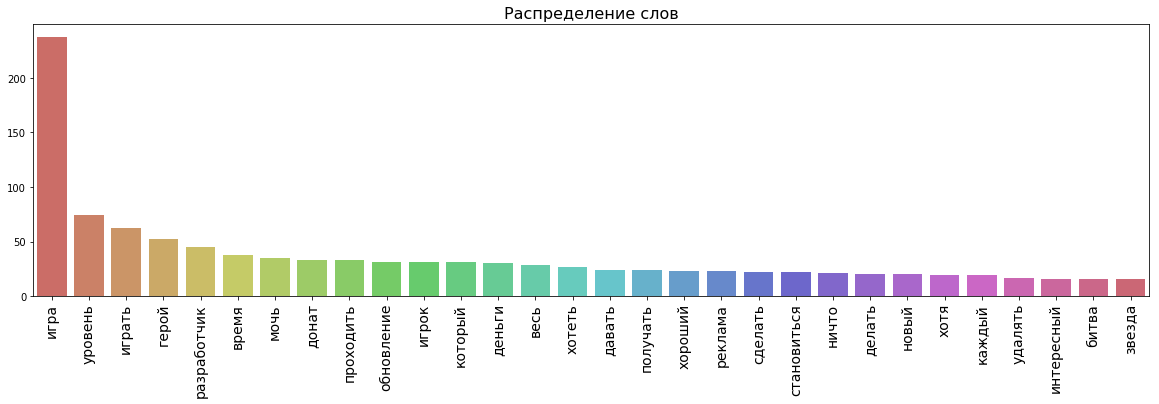

In [160]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

sns.barplot(list(range(30)), tokenized_only_df['count'].values[:30], palette='hls', ax=ax)

ax.set_xticks(list(range(30)))
ax.set_xticklabels(tokenized_only_df.index[:30], fontsize=14, rotation=90)
ax.set_title("Распределение слов", fontsize=16);